<a href="https://colab.research.google.com/github/sabeesh90/Inverted_Architecture_Efficient_Neural_Networks-Casting_Products/blob/main/Defective_piece_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import os
import tempfile
from skimage import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers

In [ ]:
#importing required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.losses as tfloss

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Automating functions

In [ ]:
from keras.models import load_model
def Load_Best_Model(strmodelname):
  best_model = load_model("/content/gdrive/MyDrive/Colab Notebooks/casting_data" + strmodelname)
  return best_model

In [ ]:
def Evaluate_ConfusionMatrix(strmodelname, test_dataset):
  model = Load_Best_Model(strmodelname)
  y_pred_prob = model.predict_generator(generator = test_dataset,
                                            verbose = 1)
  THRESHOLD = 0.5
  y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
  y_true_class = test_dataset.classes[test_dataset.index_array]

  pd.DataFrame(
      confusion_matrix(y_true_class, y_pred_class),
      index = [["Actual", "Actual"], ["ok", "defect"]],
      columns = [["Predicted", "Predicted"], ["ok", "defect"]],
  )

  plt.figure(figsize=(10,6))
  sns.heatmap(confusion_matrix(test_dataset.classes,y_pred_class),annot=True)
  plt.show()  

In [ ]:
def Evaluate_TestAccuracy_ModelSize(model_name, test_dataset):
  
  best_model = Load_Best_Model(model_name)
  
  test_images = np.concatenate([test_dataset.next()[0] for i in range(test_dataset.__len__())])
  test_labels = np.concatenate([test_dataset.next()[1] for i in range(test_dataset.__len__())])

  #def test_accuracy()
  _, baseline_model_accuracy = best_model.evaluate(
      test_images, test_labels, verbose=0)

  print('Test Accuracy:', baseline_model_accuracy)  

  keras_file = tempfile.mktemp('.h5') # Doubt 1 -Why are we creating a temp file here again. we already have the best model saved right?
  tf.keras.models.save_model(best_model, keras_file, include_optimizer=False)
  print('Saved baseline model to:', keras_file)

  model_size = round(os.path.getsize(keras_file)/1000000,2)
  print("Model_Size:", model_size, "MB")
  return best_model, baseline_model_accuracy, model_size

In [ ]:

# plot_model_loss_accuracy(model, my_model)
def plot_graphs(model):
    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('Loss Curves')
    plt.legend(['train loss', 'val loss'])

    plt.subplot(122)
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('Accuracy Curves')
    plt.legend(['train Acc', 'val acc'])
    plt.show()


In [ ]:
import time
def inference_times(my_model, test_dataset1=test_dataset1,test_dataset10=test_dataset10,test_dataset50=test_dataset50,test_dataset100=test_dataset100, test_dataset715=test_dataset715):
    start = time.time()
    my_model.predict(test_dataset1, batch_size = 1)
    end = time.time()
    print(end - start,(end - start)/715)

    start = time.time()
    my_model.predict(test_dataset10, batch_size = 10)
    end = time.time()
    print(end - start, (end - start)/72)

    start = time.time()
    my_model.predict(test_dataset50, batch_size = 32)
    end = time.time()
    print(end - start, (end - start)/23)

    start = time.time()
    my_model.predict(test_dataset100, batch_size = 100)
    end = time.time()
    print(end - start, (end - start)/8)

    start = time.time()
    my_model.predict(test_dataset715, batch_size = 715)
    end = time.time()
    print(end - start, (end - start)/1)


def inference_times_aug(my_model, test_dataset1=test_dataset1_aug,test_dataset10=test_dataset10_aug,test_dataset50=test_dataset50_aug,test_dataset100=test_dataset100_aug, test_dataset715=test_dataset715_aug):
    start = time.time()
    my_model.predict(test_dataset1, batch_size = 1)
    end = time.time()
    print(end - start,(end - start)/715)

    start = time.time()
    my_model.predict(test_dataset10, batch_size = 10)
    end = time.time()
    print(end - start, (end - start)/72)

    start = time.time()
    my_model.predict(test_dataset50, batch_size = 32)
    end = time.time()
    print(end - start, (end - start)/23)

    start = time.time()
    my_model.predict(test_dataset100, batch_size = 100)
    end = time.time()
    print(end - start, (end - start)/8)

    start = time.time()
    my_model.predict(test_dataset715, batch_size = 715)
    end = time.time()
    print(end - start, (end - start)/1)



# Creating the train and test generator

In [ ]:
defect_cls = ['def_front', 'ok_front']

DATASET_PATH = '/content/gdrive/MyDrive/Colab Notebooks/casting_data/'
train_path = DATASET_PATH + 'train/'
test_path = DATASET_PATH + 'test/'

image_shape = (300,300,3)
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32
SEED_NUMBER = 123

In [ ]:
# creating the train dataset
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32
SEED_NUMBER = 123


# for the transfer learning models
gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER)
train_generator = ImageDataGenerator(rescale = 1./255,validation_split = 0.2)
train_dataset = train_generator.flow_from_directory(directory = train_path,subset = "training", shuffle = True, **gen_args)
validation_dataset = train_generator.flow_from_directory(directory = train_path,subset = "validation", shuffle = True, **gen_args)

test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = test_path, shuffle= False, **gen_args)

# Augmmented dataset
train_generator_aug = ImageDataGenerator(rescale = 1./255,validation_split = 0.2,zca_whitening = True, rotation_range = 4, zoom_range = 0.2, shear_range=0.2,horizontal_flip = True, vertical_flip = True)
train_dataset_aug = train_generator_aug.flow_from_directory(directory = train_path,subset = "training", shuffle = True, **gen_args)
validation_dataset_aug = train_generator_aug.flow_from_directory(directory = train_path,subset = "validation", shuffle = True, **gen_args)

test_generator_aug = ImageDataGenerator(rescale = 1./255, zca_whitening = True, rotation_range = 4, zoom_range = 0.2, shear_range=0.2,horizontal_flip = True, vertical_flip = True)
test_dataset_aug = test_generator_aug.flow_from_directory(directory = test_path, shuffle= False, **gen_args)




Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
np.unique(test_dataset.classes, return_counts = True)
    

(array([0, 1], dtype=int32), array([262, 453]))

In [ ]:
test_dataset1 = test_generator.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 1,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset10 = test_generator.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 10,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset50 = test_generator.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 50,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset100 = test_generator.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 100,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset715 = test_generator.flow_from_directory(directory = test_path,
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 715,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )

Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
test_dataset1_aug = test_generator_aug.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 1,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset10_aug = test_generator_aug.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 10,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset50_aug = test_generator_aug.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 50,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset100_aug = test_generator_aug.flow_from_directory(directory = test_path, 
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 100,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )
test_dataset715_aug = test_generator_aug.flow_from_directory(directory = test_path,
                shuffle= False, **dict(target_size = IMAGE_SIZE,
                color_mode = "rgb",
                batch_size = 715,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},                
                seed = SEED_NUMBER),
                )

Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
print('There are a total of these many batches in test dataset1',len(test_dataset1))
print('There are a total of these many batches in test dataset10',len(test_dataset10))
print('There are a total of these many batches in test dataset32',len(test_dataset))
print('There are a total of these many batches in test dataset100',len(test_dataset100))
print('There are a total of these many batches in test dataset715',len(test_dataset715))
# print(len(test_dataset100))

There are a total of these many batches in test dataset1 715
There are a total of these many batches in test dataset10 72
There are a total of these many batches in test dataset32 23
There are a total of these many batches in test dataset100 8
There are a total of these many batches in test dataset715 1


# Custom Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

#Creating model
image_shape=(300,300,3)
model = Sequential()

# firt sconvolutional block
model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=image_shape, activation='relu'))   # image size / channels  - 330 / 3 output  - 298/ 16
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))  # iamge size/channels  input - 298/16 output - 149/16 

# second convolutional block
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',)) # image size/channels  - input 149/16 output 147/16
model.add(MaxPooling2D(pool_size=(2, 2))) # image size/channels  - input 147/16 output 73/16

# third convolutional block
model.add(Conv2D(filters=8, kernel_size=(3,3),  activation='relu',))# image size/channels  - input 73/16 output 71/8
model.add(MaxPooling2D(pool_size=(2, 2)))# image size/channels  - input 71/8 output 35/8

# fourth convolutional block
model.add(Conv2D(filters=8, kernel_size=(3,3),  activation='relu',)) # image size/channels  - input 35/8 output 33/8
model.add(BatchNormalization())


# fifth convolutional block
model.add(Conv2D(filters=8, kernel_size=(3,3),  activation='relu',)) # image size/channels  - input 33/8 output 16/8
model.add(BatchNormalization())

model.add(layers.GlobalAveragePooling2D())  # image size/channels  - input 16/8 output 1/8
model.add(Dense(64))
model.add(Activation('relu'))

# Last layer
model.add(Dense(1))
model.add(Activation('sigmoid')) # Doubt 3: why perform sigmoid on a single  class output? The model  will learn only features pertaining to one class.the other classwont be learnt

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
batch_normalization_3 (Batch (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 16)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 8)        

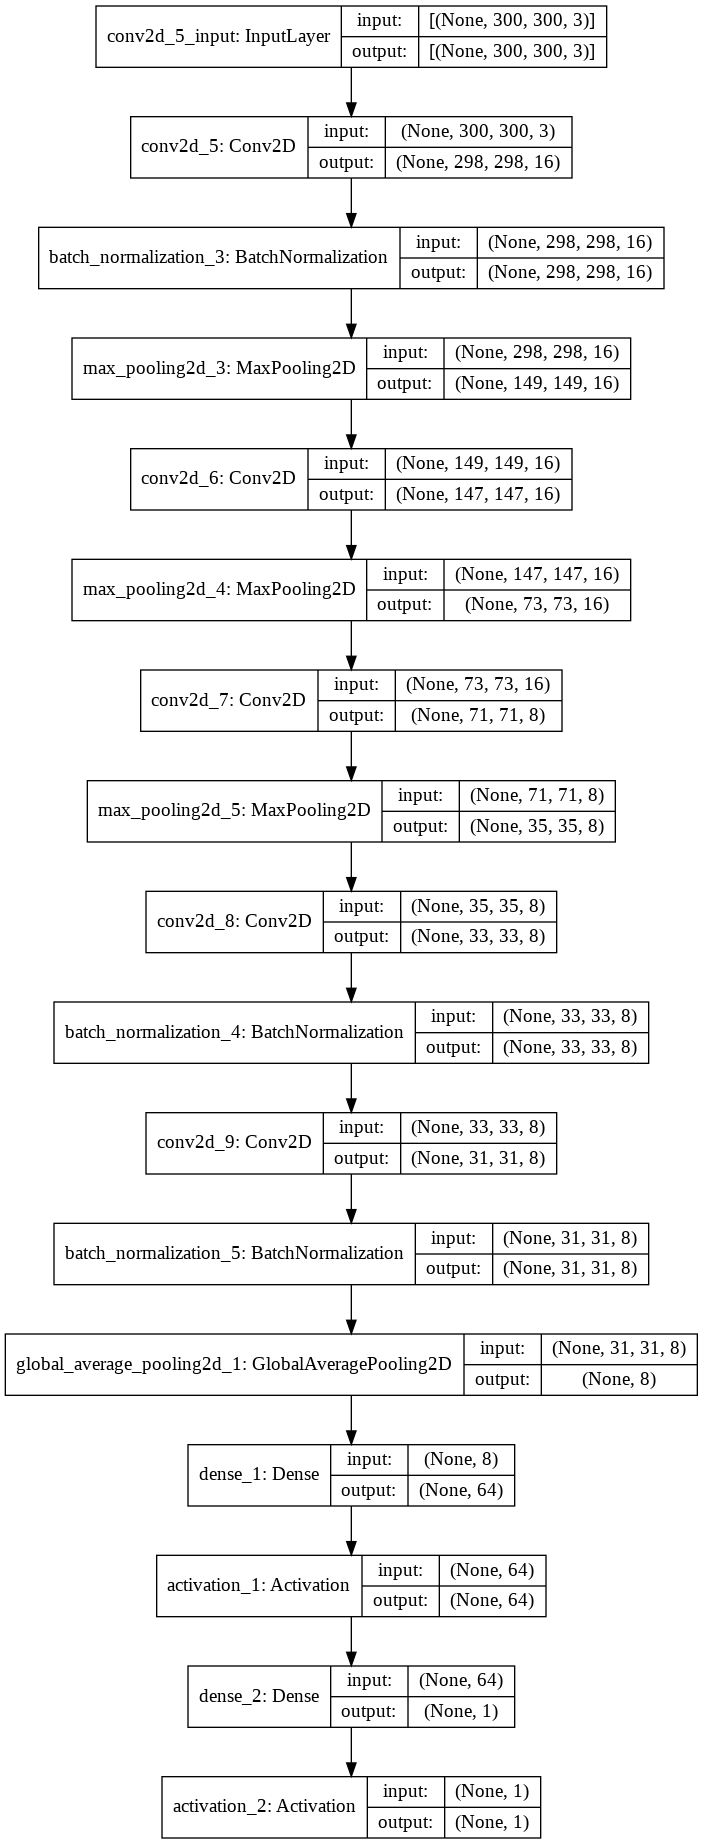

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, dpi = 96, show_shapes = True)

Augmented dataset

In [ ]:
checkpoint_aug = ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new_aug.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_accuracy")

model.fit_generator(generator = train_dataset_aug,
                    validation_data = validation_dataset_aug,
                    steps_per_epoch = len(train_dataset_aug),
                    epochs = 20,
                    validation_steps = len(validation_dataset_aug),
                    callbacks = [checkpoint_aug, reduce_lr ],
                    verbose = 1)

Epoch 1/20
166/166 [==============================] - 1382s 8s/step - loss: 0.4697 - accuracy: 0.8219 - val_loss: 1.4487 - val_accuracy: 0.5664

Epoch 00001: val_accuracy improved from -inf to 0.56637, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new_aug.hdf5
Epoch 2/20
166/166 [==============================] - 297s 2s/step - loss: 0.2239 - accuracy: 0.9169 - val_loss: 0.3350 - val_accuracy: 0.8831

Epoch 00002: val_accuracy improved from 0.56637 to 0.88311, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new_aug.hdf5
Epoch 3/20
166/166 [==============================] - 296s 2s/step - loss: 0.1638 - accuracy: 0.9365 - val_loss: 1.9734 - val_accuracy: 0.4706

Epoch 00003: val_accuracy did not improve from 0.88311
Epoch 4/20
166/166 [==============================] - 294s 2s/step - loss: 0.1324 - accuracy: 0.9491 - val_loss: 5.4073 - val_accuracy: 0.4336

Epoch 00004: val_accuracy did

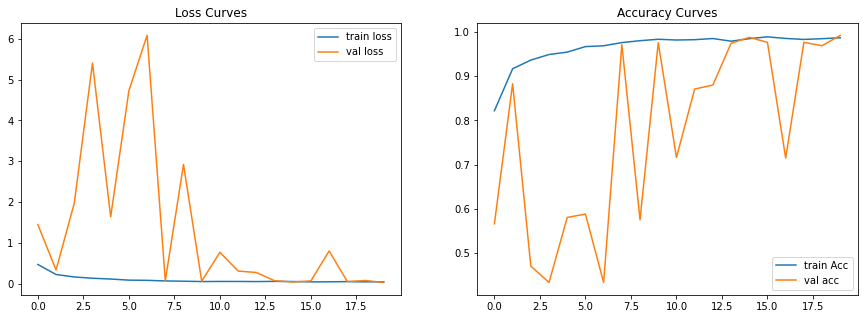

In [ ]:
plot_graphs(model) # training curves augmented training

In [ ]:
best_custom_model, custom_model_Acc, custom_model_size = Evaluate_TestAccuracy_ModelSize("/cnn_casting_inspection_model_new_aug.hdf5", test_dataset)
os.stat('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new_aug.hdf5').st_size

Test Accuracy: 0.9916083812713623
Saved baseline model to: /tmp/tmpw0rdpv7d.h5
Model_Size: 0.08 MB


167152

In [ ]:
# augmented model on normal dataset
THRESHOLD = 0.5
y_pred_prob = best_custom_model.predict_generator(generator = test_dataset,verbose = 1)
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]
print(classification_report(y_true_class, y_pred_class, digits = 4))



23/23 [==============================] - 9s 368ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9771    0.9884       262
           1     0.9869    1.0000    0.9934       453

    accuracy                         0.9916       715
   macro avg     0.9935    0.9885    0.9909       715
weighted avg     0.9917    0.9916    0.9916       715



In [ ]:
# augmented model on augmented dataset
THRESHOLD = 0.5
y_pred_prob = best_custom_model.predict_generator(generator = test_dataset_aug,verbose = 1)
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset_aug.classes[test_dataset_aug.index_array]
print(classification_report(y_true_class, y_pred_class, digits = 4))


23/23 [==============================] - 23s 981ms/step
              precision    recall  f1-score   support

           0     0.9921    0.9580    0.9748       262
           1     0.9762    0.9956    0.9858       453

    accuracy                         0.9818       715
   macro avg     0.9841    0.9768    0.9803       715
weighted avg     0.9820    0.9818    0.9817       715



In [ ]:
my_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new_aug.hdf5')

In [ ]:
inference_times(my_model)

13.892488241195679 0.01943005348418976
11.286256790161133 0.15675356653001574
10.494836330413818 0.45629723175712256
9.634612798690796 1.2043265998363495
12.827758550643921 12.827758550643921


In [ ]:
inference_times_aug(my_model)

35.976763010025024 0.05031715106297206
24.375577688217163 0.3385496901141273
42.10171627998352 1.8305094034775444
28.28774094581604 3.535967618227005
41.34475040435791 41.34475040435791


Non Augmented dataset

In [ ]:
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs = 20,
                    validation_steps = len(validation_dataset),
                    callbacks = [checkpoint, reduce_lr ],
                    verbose = 1)

Epoch 1/20
166/166 [==============================] - 1596s 10s/step - loss: 0.4087 - accuracy: 0.8707 - val_loss: 0.9923 - val_accuracy: 0.5664

Epoch 00001: val_loss improved from inf to 0.99229, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new.hdf5
Epoch 2/20
166/166 [==============================] - 21s 125ms/step - loss: 0.1511 - accuracy: 0.9478 - val_loss: 3.3115 - val_accuracy: 0.4336

Epoch 00002: val_loss did not improve from 0.99229
Epoch 3/20
166/166 [==============================] - 21s 124ms/step - loss: 0.1105 - accuracy: 0.9572 - val_loss: 1.6185 - val_accuracy: 0.5845

Epoch 00003: val_loss did not improve from 0.99229
Epoch 4/20
166/166 [==============================] - 21s 125ms/step - loss: 0.0864 - accuracy: 0.9704 - val_loss: 1.1082 - val_accuracy: 0.6916

Epoch 00004: val_loss did not improve from 0.99229
Epoch 5/20
166/166 [==============================] - 21s 125ms/step - loss: 0.0603 - accuracy: 0.9781 -

In [ ]:
my_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new.hdf5')

In [ ]:
# normal model on augmented dataset
best_custom_model, custom_model_Acc, custom_model_size = Evaluate_TestAccuracy_ModelSize("/cnn_casting_inspection_model_new.hdf5", test_dataset)

THRESHOLD = 0.5
y_pred_prob = best_custom_model.predict_generator(generator = test_dataset_aug,verbose = 1)
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset_aug.classes[test_dataset_aug.index_array]
print(classification_report(y_true_class, y_pred_class, digits = 4))



Test Accuracy: 0.9944055676460266
Saved baseline model to: /tmp/tmpyyxx1kv7.h5
Model_Size: 0.08 MB
23/23 [==============================] - 21s 905ms/step
              precision    recall  f1-score   support

           0     0.9844    0.9618    0.9730       262
           1     0.9782    0.9912    0.9846       453

    accuracy                         0.9804       715
   macro avg     0.9813    0.9765    0.9788       715
weighted avg     0.9805    0.9804    0.9804       715



In [ ]:
# normal model on augmented dataset inference timings
inference_times_aug(my_model)

21.4377019405365 0.029982799916834266
21.38748049736023 0.2970483402411143
22.0416362285614 0.9583320099374523
23.258629083633423 2.907328635454178
56.4210250377655 56.4210250377655


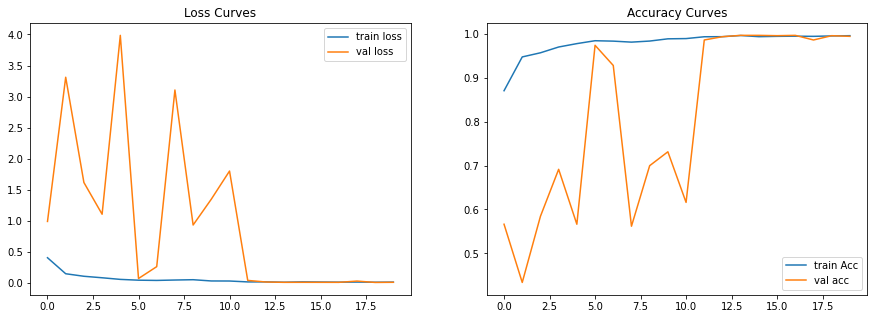

In [ ]:

# plot_model_loss_accuracy(model, my_model)
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss Curves')
plt.legend(['train loss', 'val loss'])

plt.subplot(122)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.legend(['train Acc', 'val acc'])
plt.show()


In [ ]:
best_custom_model, custom_model_Acc, custom_model_size = Evaluate_TestAccuracy_ModelSize("/cnn_casting_inspection_model_new.hdf5", test_dataset)
os.stat('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_new.hdf5').st_size

Test Accuracy: 0.9944055676460266
Saved baseline model to: /tmp/tmp2jy2y1sr.h5
Model_Size: 0.08 MB


167152

In [ ]:
THRESHOLD = 0.5
y_pred_prob = best_custom_model.predict_generator(generator = test_dataset,verbose = 1)
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]
print(classification_report(y_true_class, y_pred_class, digits = 4))


23/23 [==============================] - 2s 94ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9847    0.9923       262
           1     0.9912    1.0000    0.9956       453

    accuracy                         0.9944       715
   macro avg     0.9956    0.9924    0.9940       715
weighted avg     0.9945    0.9944    0.9944       715



In [ ]:
inference_times(my_model)

12.651184558868408 0.017693964417997775
9.676875591278076 0.13440104987886217
9.053744554519653 0.39364106758781103
9.483142614364624 1.185392826795578
12.619876146316528 12.619876146316528


In [ ]:
a = time.time()
print('a')
b  = time.time()
b-a

a


8.869171142578125e-05

# Transfer Learning models

In [ ]:
from tensorflow import keras
img_height = 300
img_width = 300
channels = 3

res = ResNet50(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width,channels),
    pooling='max',
    classes=2,
)

mob = MobileNetV2(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=2,
)
eff = EfficientNetB2(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=2,
)



# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
input_res = res.inputs
output_res = res.output
x_res = Dense(2, activation  = 'softmax')(output_res)
res_model = Model(inputs = input_res, outputs = x_res)
res_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


input_eff = eff.inputs
output_eff = eff.output
x_eff = Dense(2, activation  = 'softmax')(output_eff)
eff_model = Model(inputs = input_eff, outputs = x_eff)
eff_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

input_mob = mob.inputs
output_mob = mob.output
x_mob = Dense(2, activation  = 'softmax')(output_mob)
mob_model = Model(inputs = input_mob, outputs = x_mob)
mob_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

checkpoint_res = ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_res.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")
checkpoint_nas = ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")
checkpoint_mob = ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_mob.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")
checkpoint_eff = ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_eff.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

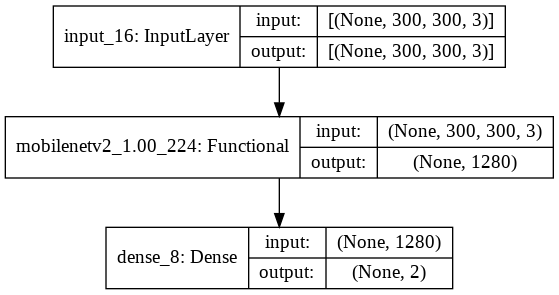

In [ ]:
from tensorflow import keras
img_height = 300
img_width = 300
channels = 3

res = ResNet50(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width,channels),
    pooling='max',
    classes=2,
)

mob = MobileNetV2(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=2,
)
eff = EfficientNetB2(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=2,
)



# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
image_i = keras.Input(shape = (300,300,3))
output_nas  = res(image_i)
x_nas = Dense(2, activation  = 'softmax')(output_nas)
res_model = Model(inputs = image_i, outputs = x_nas)
res_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


image_i = keras.Input(shape = (300,300,3))
output_nas  = eff(image_i)
x_nas = Dense(2, activation  = 'softmax')(output_nas)
eff_model = Model(inputs = image_i, outputs = x_nas)
eff_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

image_i = keras.Input(shape = (300,300,3))
output_nas  = mob(image_i)
x_nas = Dense(2, activation  = 'softmax')(output_nas)
mob_model = Model(inputs = image_i, outputs = x_nas)
mob_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

keras.utils.plot_model(res_model, show_shapes=True)
# keras.utils.plot_mode(eff_model, show_shapes=True)
keras.utils.plot_model(mob_model, show_shapes=True)

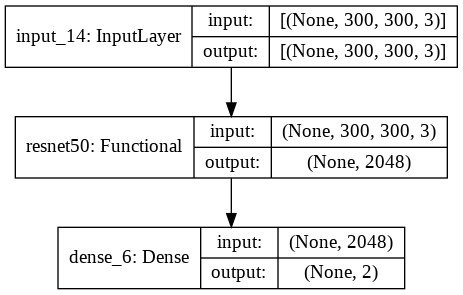

In [ ]:
keras.utils.plot_model(res_model, show_shapes=True)

In [ ]:
nas = NASNetMobile(
    include_top=False,
    weights="imagenet",    
    input_shape=(224,224,3),
    pooling='max',
    classes=2,
)

In [ ]:
image_i = keras.Input(shape = (300,300,3))
image_input = keras.layers.experimental.preprocessing.Resizing(224,224)(image_i)
output_nas  = nas(image_input)
x_nas = Dense(2, activation  = 'softmax')(output_nas)

nas_model = Model(inputs = image_i, outputs = x_nas)
nas_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# RESNET50

In [ ]:
res_model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs = 20,
                    validation_steps = len(validation_dataset),
                    callbacks = [checkpoint_res],
                    verbose = 1)

Epoch 1/20
166/166 [==============================] - 1700s 10s/step - loss: 0.3115 - accuracy: 0.9668 - val_loss: 4.6942 - val_accuracy: 0.5664

Epoch 00001: val_loss improved from inf to 4.69420, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_res.hdf5
Epoch 2/20
166/166 [==============================] - 110s 664ms/step - loss: 0.2133 - accuracy: 0.9853 - val_loss: 8.0499 - val_accuracy: 0.5664

Epoch 00002: val_loss did not improve from 4.69420
Epoch 3/20
166/166 [==============================] - 110s 662ms/step - loss: 0.0621 - accuracy: 0.9943 - val_loss: 13.8560 - val_accuracy: 0.5664

Epoch 00003: val_loss did not improve from 4.69420
Epoch 4/20
166/166 [==============================] - 110s 661ms/step - loss: 0.1326 - accuracy: 0.9925 - val_loss: 1.7095 - val_accuracy: 0.4940

Epoch 00004: val_loss improved from 4.69420 to 1.70948, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_mod

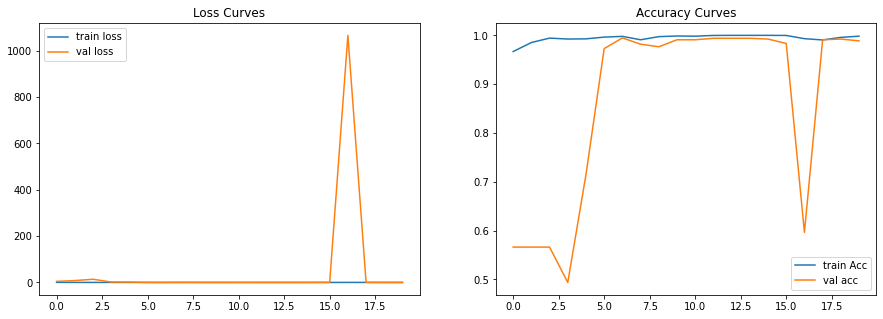

In [ ]:
plot_graphs(res_model)

In [ ]:
best_custom_model, custom_model_Acc, custom_model_size = Evaluate_TestAccuracy_ModelSize("/cnn_casting_inspection_model_res.hdf5", test_dataset)
os.stat('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_res.hdf5').st_size

Test Accuracy: 0.9916083812713623
Saved baseline model to: /tmp/tmpbr_thdqx.h5
Model_Size: 94.89 MB


283705112

In [ ]:
my_res_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_res.hdf5')

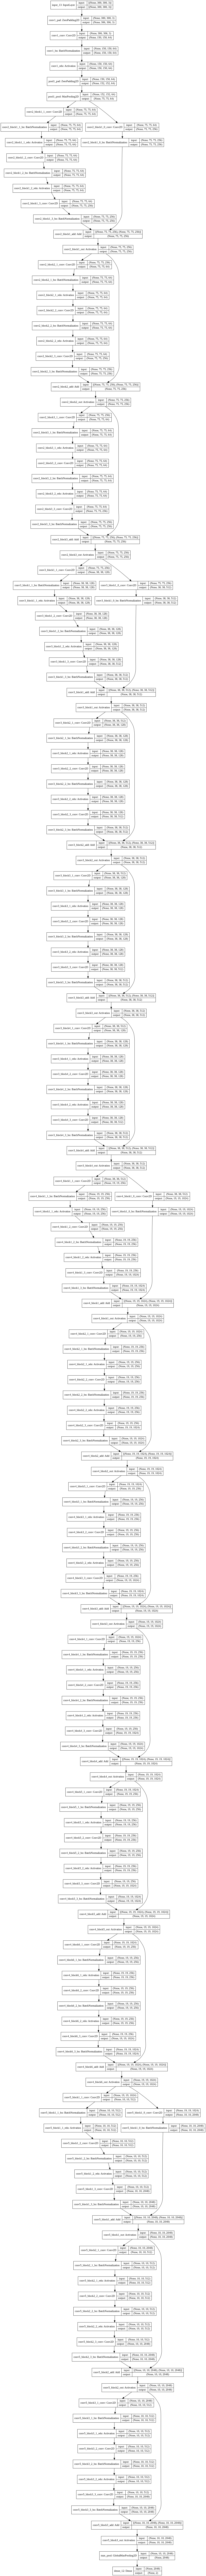

In [ ]:
my_res_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_res.hdf5')
keras.utils.plot_model(my_res_model, dpi = 96, show_shapes = True)

In [ ]:
inference_times(my_res_model)

114.1440589427948 0.15964204047943328
95.790203332901 1.3304194907347362
82.2953953742981 3.578060668447743
76.6457998752594 9.580724984407425
76.73295521736145 76.73295521736145


In [ ]:
my_res_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
my_res_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_res.hdf5')
y_pred_prob = np.argmax(my_res_model.predict(test_dataset), axis = -1)
y_true_class = test_dataset.classes[test_dataset.index_array]
print(classification_report(y_true_class, y_pred_prob, digits = 4))


              precision    recall  f1-score   support

           0     0.9848    0.9924    0.9886       262
           1     0.9956    0.9912    0.9934       453

    accuracy                         0.9916       715
   macro avg     0.9902    0.9918    0.9910       715
weighted avg     0.9916    0.9916    0.9916       715



# NASNET

In [ ]:

nas_model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs = 20,
                    validation_steps = len(validation_dataset),
                    callbacks = [checkpoint_nas],
                    verbose = 1)

Epoch 1/20
166/166 [==============================] - 948s 5s/step - loss: 0.1447 - accuracy: 0.9572 - val_loss: 1.0398 - val_accuracy: 0.6011

Epoch 00001: val_loss improved from inf to 1.03979, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5
Epoch 2/20
166/166 [==============================] - 66s 397ms/step - loss: 0.0195 - accuracy: 0.9945 - val_loss: 1.2516 - val_accuracy: 0.5845

Epoch 00002: val_loss did not improve from 1.03979
Epoch 3/20
166/166 [==============================] - 66s 398ms/step - loss: 0.0143 - accuracy: 0.9949 - val_loss: 0.5776 - val_accuracy: 0.7413

Epoch 00003: val_loss improved from 1.03979 to 0.57758, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5
Epoch 4/20
166/166 [==============================] - 66s 398ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 1.4705 - val_accuracy: 0.5385

Epoch 00004: val_loss did not improve from 0.

In [ ]:
nas_model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs = 20,
                    validation_steps = len(validation_dataset),
                    callbacks = [checkpoint_nas],
                    verbose = 1)

Epoch 1/20
166/166 [==============================] - 66s 400ms/step - loss: 4.8732e-05 - accuracy: 1.0000 - val_loss: 0.1254 - val_accuracy: 0.9781

Epoch 00001: val_loss did not improve from 0.11543
Epoch 2/20
166/166 [==============================] - 66s 398ms/step - loss: 1.8450e-05 - accuracy: 1.0000 - val_loss: 0.1090 - val_accuracy: 0.9834

Epoch 00002: val_loss improved from 0.11543 to 0.10902, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5
Epoch 3/20
166/166 [==============================] - 66s 396ms/step - loss: 1.4682e-05 - accuracy: 1.0000 - val_loss: 0.0944 - val_accuracy: 0.9879

Epoch 00003: val_loss improved from 0.10902 to 0.09445, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5
Epoch 4/20
166/166 [==============================] - 66s 396ms/step - loss: 7.6503e-05 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9872

Epoch 00004: val_loss d

In [ ]:
best_custom_model, custom_model_Acc, custom_model_size = Evaluate_TestAccuracy_ModelSize("/cnn_casting_inspection_model_nas.hdf5", test_dataset) # .h5
os.stat('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5').st_size # .hdf5

Test Accuracy: 0.9930070042610168
Saved baseline model to: /tmp/tmp7srp723w.h5
Model_Size: 18.35 MB


53982632

In [ ]:
plot_graphs(nas_model)

In [ ]:
my_nas_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5')
inference_times(my_nas_model)

40.9035861492157 0.05720781279610587
85.21266150474548 1.1835091875659094
82.0813558101654 3.568754600441974
28.13391351699829 3.5167391896247864
26.651702880859375 26.651702880859375


In [ ]:
my_nas_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_nas.hdf5')
my_nas_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
resizing_7 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 1056)              4269716   
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 2114      
Total params: 4,271,830
Trainable params: 4,235,092
Non-trainable params: 36,738
_________________________________________________________________


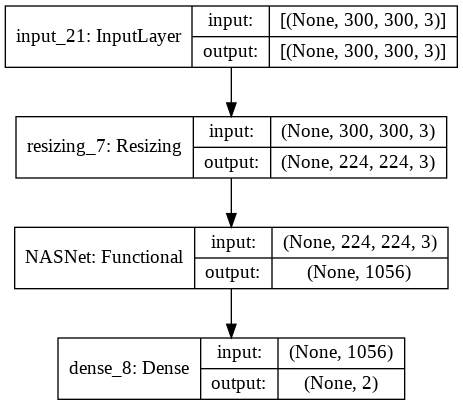

In [ ]:
keras.utils.plot_model(my_nas_model, show_shapes = True)

In [ ]:

y_pred_prob = np.argmax(my_nas_model.predict(test_dataset), axis = -1)
y_true_class = test_dataset.classes[test_dataset.index_array]
print(classification_report(y_true_class, y_pred_prob, digits = 4))


              precision    recall  f1-score   support

           0     1.0000    0.9809    0.9904       262
           1     0.9891    1.0000    0.9945       453

    accuracy                         0.9930       715
   macro avg     0.9945    0.9905    0.9924       715
weighted avg     0.9931    0.9930    0.9930       715



# EFFNET B2

In [ ]:
eff_model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs = 20,
                    validation_steps = len(validation_dataset),
                    callbacks = [checkpoint_eff],
                    verbose = 1)

Epoch 1/20
166/166 [==============================] - 159s 899ms/step - loss: 0.1855 - accuracy: 0.9429 - val_loss: 1.8230 - val_accuracy: 0.5664

Epoch 00001: val_loss improved from inf to 1.82301, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_eff.hdf5
Epoch 2/20
166/166 [==============================] - 149s 895ms/step - loss: 0.0508 - accuracy: 0.9864 - val_loss: 0.7610 - val_accuracy: 0.5920

Epoch 00002: val_loss improved from 1.82301 to 0.76101, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_eff.hdf5
Epoch 3/20
166/166 [==============================] - 149s 898ms/step - loss: 0.0336 - accuracy: 0.9917 - val_loss: 0.9283 - val_accuracy: 0.6561

Epoch 00003: val_loss did not improve from 0.76101
Epoch 4/20
166/166 [==============================] - 150s 903ms/step - loss: 0.0241 - accuracy: 0.9940 - val_loss: 0.4549 - val_accuracy: 0.8914

Epoch 00004: val_loss improved from 0.7

In [ ]:
best_custom_model, custom_model_Acc, custom_model_size = Evaluate_TestAccuracy_ModelSize("/cnn_casting_inspection_model_eff.hdf5", test_dataset)
os.stat('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_eff.hdf5').st_size

Test Accuracy: 0.6335664391517639
Saved baseline model to: /tmp/tmpfsplt5wv.h5
Model_Size: 32.01 MB


94372448

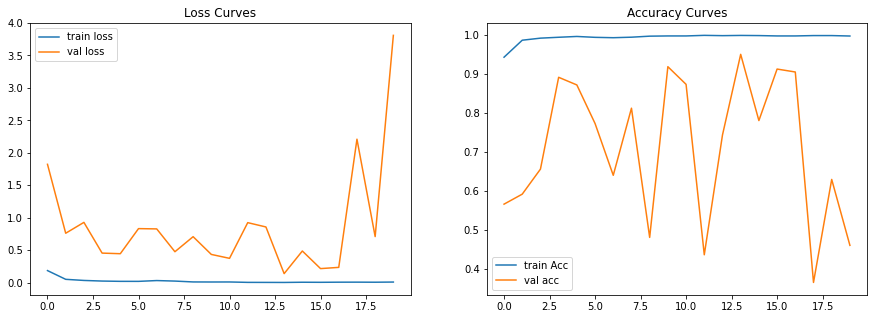

In [ ]:
plot_graphs(eff_model)

In [ ]:
my_eff_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_eff.hdf5')
y_pred_prob = np.argmax(my_eff_model.predict(test_dataset), axis = -1)
y_true_class = test_dataset.classes[test_dataset.index_array]
print(classification_report(y_true_class, y_pred_prob, digits = 4))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       262
           1     0.6336    1.0000    0.7757       453

    accuracy                         0.6336       715
   macro avg     0.3168    0.5000    0.3878       715
weighted avg     0.4014    0.6336    0.4914       715



# MOBIE NET

In [ ]:
mob_model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = len(train_dataset),
                    epochs = 20,
                    validation_steps = len(validation_dataset),
                    callbacks = [checkpoint_mob],
                    verbose = 1)

Epoch 1/20
166/166 [==============================] - 73s 411ms/step - loss: 0.1523 - accuracy: 0.9531 - val_loss: 2.7766 - val_accuracy: 0.4449

Epoch 00001: val_loss improved from inf to 2.77656, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_mob.hdf5
Epoch 2/20
166/166 [==============================] - 66s 400ms/step - loss: 0.0197 - accuracy: 0.9947 - val_loss: 1.5781 - val_accuracy: 0.5400

Epoch 00002: val_loss improved from 2.77656 to 1.57812, saving model to /content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_mob.hdf5
Epoch 3/20
166/166 [==============================] - 66s 399ms/step - loss: 0.0136 - accuracy: 0.9957 - val_loss: 3.8625 - val_accuracy: 0.4502

Epoch 00003: val_loss did not improve from 1.57812
Epoch 4/20
166/166 [==============================] - 68s 407ms/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 3.2756 - val_accuracy: 0.4774

Epoch 00004: val_loss did not improve from 

In [ ]:
best_custom_model, custom_model_Acc, custom_model_size = Evaluate_TestAccuracy_ModelSize("/cnn_casting_inspection_model_mob.hdf5", test_dataset)
os.stat('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_mob.hdf5').st_size

Test Accuracy: 0.9804195761680603
Saved baseline model to: /tmp/tmpgy8y9w1z.h5
Model_Size: 9.52 MB


27724656

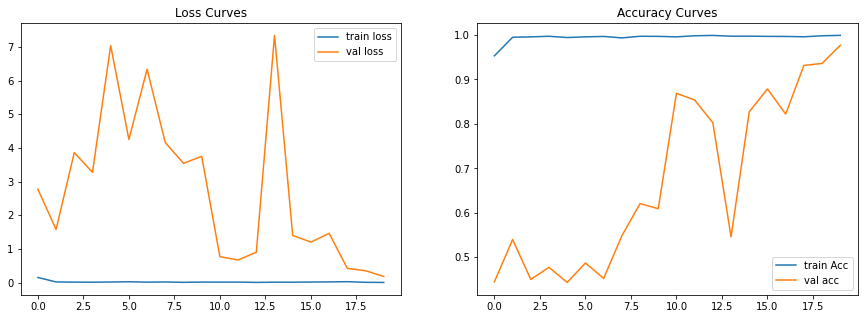

In [ ]:
plot_graphs(mob_model)

In [ ]:
my_mob_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_mob.hdf5')
y_pred_prob = np.argmax(my_mob_model.predict(test_dataset), axis = -1)
y_true_class = test_dataset.classes[test_dataset.index_array]
print(classification_report(y_true_class, y_pred_prob, digits = 4))


              precision    recall  f1-score   support

           0     0.9493    1.0000    0.9740       262
           1     1.0000    0.9691    0.9843       453

    accuracy                         0.9804       715
   macro avg     0.9746    0.9845    0.9791       715
weighted avg     0.9814    0.9804    0.9805       715



In [ ]:
my_mob_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_mob.hdf5')
inference_times(my_mob_model)

32.604817628860474 0.0456011435368678
22.690134525299072 0.3151407572958205
29.832353830337524 1.2970588621885881
21.56738781929016 2.69592347741127
21.72042179107666 21.72042179107666


In [ ]:
my_mob_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/casting_data/cnn_casting_inspection_model_mob.hdf5')
my_mob_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_23[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

# OUT OF SCOPE CODE

In [ ]:

print(classification_report(y_true_class, y_pred_class, digits = 4))

In [ ]:
images, labels = next(iter(test_dataset))
images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
fig, axes = plt.subplots(4, 4, figsize=(16,16))
THRESHOLD = 0.5

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap = "gray")
    true_label = mapping_class[label]
    
    [[pred_prob]] = best_custom_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("TRUE VS PREDICTED LABEL FOR 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

In [ ]:

THRESHOLD = 0.5
y_pred_prob = best_custom_model.predict_generator(generator = test_dataset,
                                           verbose = 1)
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

In [ ]:
misclassify_pred = np.nonzero(y_pred_class != y_true_class)[0]

fig, axes = plt.subplots(1, 2, figsize=(8, 8))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    images, labels = test_dataset[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*IMAGE_SIZE), cmap = "gray")
    
    true_label = mapping_class[labels[image_num]]
    [[pred_prob]] = best_custom_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(y_true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()

In [ ]:
train_images = np.concatenate([train_dataset.next()[0] for i in range(train_dataset.__len__())])
train_labels = np.concatenate([train_dataset.next()[1] for i in range(train_dataset.__len__())])
#test_images = np.concatenate([test_dataset.next()[0] for i in range(test_dataset.__len__())])
#test_labels = np.concatenate([test_dataset.next()[1] for i in range(test_dataset.__len__())])

In [ ]:
test_images = np.concatenate([test_dataset.next()[0] for i in range(test_dataset.__len__())])
test_labels = np.concatenate([test_dataset.next()[1] for i in range(test_dataset.__len__())])

# Pruning and TFlite Conversion

In [ ]:
def Apply_Pruning_to_base_model(model):

  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Compute end step to finish pruning after 2 epochs.
  batch_size = 32
  epochs = 5
  validation_split = 0.2 # 10% of training set will be used for validation set. 

  num_images = train_images.shape[0] * (1 - validation_split)
  end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

  # Define model for pruning.a
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step = end_step)
  }

  model_for_pruning = prune_low_magnitude(model, **pruning_params)


  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss='binary_crossentropy',#tfloss.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]
    
  model_for_pruning.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=validation_split,
                    callbacks=callbacks)
  return model_for_pruning
  #model_for_pruning.summary()

In [ ]:
pruned_custom_model = Apply_Pruning_to_base_model(best_custom_model)

In [ ]:
def pruned_model_accuracy(pruned_model):
  _, pruned_custom_model_accuracy = pruned_model.evaluate(
    test_images, test_labels, verbose=0)

  print('Pruned test accuracy:', pruned_custom_model_accuracy)
  return pruned_custom_model_accuracy

In [ ]:
pruned_custom_model_acc = pruned_model_accuracy(pruned_custom_model)

In [ ]:
%tensorboard --logdir={logdir}

In [ ]:
#create sparse model after pruning
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_custom_model)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
os.path.getsize(pruned_keras_file)

In [ ]:
#Convert the pruned model to tfite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

In [ ]:
os.path.getsize(pruned_tflite_file)

# Quantization of pruned model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model_custom = converter.convert()

_, quantized_and_pruned_tflite_file_custom = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file_custom, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model_custom)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file_custom)
os.path.getsize(quantized_and_pruned_tflite_file_custom)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
#print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

In [ ]:
import numpy as np

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
    prediction_defective = []
    for i, test_image in enumerate(test_images):
        if i % 700 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_defective.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_defective = np.array(prediction_defective)
    accuracy = (prediction_defective == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model_custom)
interpreter.allocate_tensors()

custom_pruned_quant_test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', custom_pruned_quant_test_accuracy)
print('Pruned TF test accuracy:', pruned_custom_model_acc)

#Weight Clustering using Keras

In [ ]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 32,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(best_custom_model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(), 
  optimizer=opt,
  metrics=['accuracy'],
 experimental_run_tf_function = False)

clustered_model.summary()

In [ ]:
import numpy as np
train_labels.astype(np.int8)

In [ ]:
clustered_model.fit(
  train_images,
  train_labels,
  batch_size=32,
  epochs=2,
  validation_split=0.1)

In [ ]:
_, clustered_custom_model_accuracy = clustered_model.evaluate(
  test_images, test_labels, verbose=0)

print('Baseline test accuracy:', custom_model_Acc)
print('Clustered test accuracy:', clustered_custom_model_accuracy)

In [ ]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model, clustered_keras_file, 
                           include_optimizer=False)

In [ ]:
os.path.getsize(quantized_and_clustered_tflite_file)

In [ ]:
clustered_tflite_file = '/tmp/clustered_mnist.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()
with open(clustered_tflite_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_file)

In [ ]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

_, quantized_and_clustered_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_clustered_tflite_file, 'wb') as f:
    f.write(tflite_quant_model)

print('Saved quantized and clustered TFLite model to:', quantized_and_clustered_tflite_file)
#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_clustered_tflite_file)))

In [ ]:
def eval_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_defective = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)        
        digit = np.argmax(output()[0])        
        prediction_defective.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_defective = np.array(prediction_defective)
    accuracy = (prediction_defective == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

Clustered_quantized_test_accuracy_custom = eval_model(interpreter)

print('Clustered and quantized TFLite test_accuracy:', Clustered_quantized_test_accuracy_custom)
print('Clustered TF test accuracy:', clustered_custom_model_accuracy)

#Float 16 Quantization using TFLite 

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(best_custom_model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

#Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [ ]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_values = []    
    for test_image in test_images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_values.append(digit)

        # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
        accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy

In [ ]:
TFLite_Quantized_float16_custom = print(evaluate_model(interpreter_fp16))

Knowledge Distillation

In [ ]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [ ]:
from tensorflow.keras import layers

In [ ]:
# Create the student
student = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(300, 300, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(1),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student)

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=best_custom_model)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(train_images, train_labels, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(test_images, test_labels)

TRANSFER LEARNING

Exploring ResNet50 Model using pre-trained layers

In [ ]:
ResNet50_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(160,160,3),
    pooling='avg', classes=2, classifier_activation='sigmoid')

In [ ]:
from keras.applications.resnet50 import preprocess_input
preprocess_input = tf.keras.applications.resnet50.preprocess_input
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.2)


In [ ]:
# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(160, 160),
        batch_size=32,
        class_mode='binary', 
        subset = 'training',
        shuffle=True)

validation_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(160,160),
        batch_size=32,
        class_mode='binary',
        subset = 'validation', 
        shuffle=True)

test_generator = data_generator.flow_from_directory(
        test_path,
        target_size=(160, 160),
        batch_size=32,
        class_mode='binary', shuffle=False) 

In [ ]:
#adding the top layers with dropout and batch normalization
#inputs = tf.keras.Input(shape=image_shape)
resnet_model = Sequential()
resnet_model.add(ResNet50_model)
resnet_model.add(Dropout(.25))
resnet_model.add(BatchNormalization())
resnet_model.add(Flatten())
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
# Say not to train first layer (ResNet) model as it is already trained
resnet_model.layers[0].trainable = False
resnet_model.summary()

In [ ]:
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/resnet_50_best_model.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

results = resnet_model.fit_generator(train_generator,                            
                                    epochs=10,
                                    validation_data=validation_generator,
                                    validation_steps= len(validation_generator),
                                    callbacks=[checkpoint])

In [ ]:
print(results.history.keys())

In [ ]:
df = pd.DataFrame(resnet_model.history.history,
                                index = range(1, 1+len(results.epoch)))
df.head()

In [ ]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(results.history['accuracy'])  
plt.plot(results.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(results.history['loss'])  
plt.plot(results.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
plot_model_loss_accuracy(resnet_model, "ResNet50 Model")

In [ ]:
Evaluate_ConfusionMatrix("resnet_50_best_model.hdf5", test_generator)

In [ ]:
ResNet50_Best_Model, ResNet_Model_Acc, ResNet50_Model_Size = Evaluate_TestAccuracy_ModelSize("resnet_50_best_model.hdf5", test_generator)

In [ ]:
#first we will find predict probability
pred_probability = resnet_model.predict_generator(test_generator)

In [ ]:
predictions = pred_probability > 0.5
#if model predict greater than 0.5 it conveted to 1 means ok_front

In [ ]:
test_images = np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_labels = np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])

In [ ]:
train_images = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
train_labels = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])

In [ ]:
y_pred_prob = resnet_model.predict_generator(generator = test_generator,b
                                           verbose = 1)

In [ ]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_generator.classes[test_generator.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

# Model Compression using Pruning, Quantization and Weight Clustering

# Pruning and TFlite Conversion

In [ ]:
pruned_ResNet50_model = Apply_Pruning_to_base_model(ResNet50_Best_Model)

In [ ]:
def pruned_model_accuracy(pruned_model):
  _, pruned_custom_model_accuracy = pruned_model.evaluate(
    test_images, test_labels, verbose=0)

  print('Pruned test accuracy:', pruned_custom_model_accuracy)
  return pruned_custom_model_accuracy

In [ ]:
pruned_custom_model_acc = pruned_model_accuracy(pruned_custom_model)

In [ ]:
%tensorboard --logdir={logdir}

In [ ]:
#create sparse model after pruning
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_custom_model)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
#Convert the pruned model to tfite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

In [ ]:
os.path.getsize(pruned_tflite_file)

# Quantization of pruned model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model_custom = converter.convert()

_, quantized_and_pruned_tflite_file_custom = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file_custom, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model_custom)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file_custom)
os.path.getsize(quantized_and_pruned_tflite_file_custom)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
#print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

In [ ]:
import numpy as np

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 715 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model_custom)
interpreter.allocate_tensors()

custom_pruned_quant_test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', custom_pruned_quant_test_accuracy)
print('Pruned TF test accuracy:', pruned_custom_model_acc)

#Weight Clustering using Keras

In [ ]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 32,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(ResNet50_Best_Model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(), 
  optimizer=opt,
  metrics=['accuracy'],
 experimental_run_tf_function = False)

clustered_model.summary()

In [ ]:
import numpy as np
train_labels.astype(np.int8)

In [ ]:
clustered_model.fit(
  train_images,
  train_labels,
  batch_size=32,
  epochs=2,
  validation_split=0.1)

In [ ]:
_, clustered_custom_model_accuracy = clustered_model.evaluate(
  test_images, test_labels, verbose=0)

print('Baseline test accuracy:', custom_model_Acc)
print('Clustered test accuracy:', clustered_custom_model_accuracy)

In [ ]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model, clustered_keras_file, 
                           include_optimizer=False)

In [ ]:
clustered_tflite_file = '/tmp/clustered_mnist.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()
with open(clustered_tflite_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_file)

In [ ]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(ResNet50_Best_Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

_, quantized_and_clustered_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_clustered_tflite_file, 'wb') as f:
    f.write(tflite_quant_model)

print('Saved quantized and clustered TFLite model to:', quantized_and_clustered_tflite_file)
#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_clustered_tflite_file)))

In [ ]:
def eval_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

Clustered_quantized_test_accuracy_custom = eval_model(interpreter)

print('Clustered and quantized TFLite test_accuracy:', Clustered_quantized_test_accuracy_custom)
print('Clustered TF test accuracy:', clustered_custom_model_accuracy)

#Float 16 Quantization using TFLite 

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(ResNet50_Best_Model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

#Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [ ]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_values = []    
    for test_image in test_images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_values.append(digit)

        # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
        accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy

In [ ]:
TFLite_Quantized_float16_custom = print(evaluate_model(interpreter))

NASNetMobile Model

In [ ]:
NASNetMobile_Model = tf.keras.applications.NASNetMobile(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling='avg',
    classes=2
)

In [ ]:
NASNetMobile_Model.trainable = False

In [ ]:
from keras.applications.nasnet import NASNetMobile, NASNetLarge

preprocess_input = tf.keras.applications.nasnet.preprocess_input
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.2)

In [ ]:
# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=32,
        class_mode='binary', 
        subset = 'training',
        shuffle=True)

validation_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=32,
        subset = 'validation',
        class_mode='binary', 
        shuffle=True)

test_generator = data_generator.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=32,
        class_mode='binary', shuffle=False)

In [ ]:
nasnet_model = Sequential()
nasnet_model.add(NASNetMobile_Model)
nasnet_model.add(Dropout(.25))
nasnet_model.add(BatchNormalization())
nasnet_model.add(Flatten())
nasnet_model.add(Dense(1, activation='sigmoid'))
nasnet_model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
# Say not to train first layer (ResNet) model as it is already trained
nasnet_model.layers[0].trainable = False
nasnet_model.summary()

In [ ]:
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/My Drive/NASNet_mobile_best.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')

In [ ]:
results = nasnet_model.fit_generator(train_generator,                            
                                  epochs=20,
                                  validation_data=validation_generator,
                                  validation_steps=len(validation_generator),
                                  callbacks=[cb_checkpointer])

In [ ]:
plot_model_loss_accuracy(nasnet_model, "NasNetModel")

In [ ]:
Evaluate_ConfusionMatrix("NASNet_mobile_best.hdf5",test_generator )

In [ ]:
NASNet_Best_Model, NASNetMobile_Acc, NASNetMobile_Model_Size = Evaluate_TestAccuracy_ModelSize("NASNet_mobile_best.hdf5", test_generator)

In [ ]:
#first we will find predict probability
pred_probability = NASNet_Best_Model.predict_generator(test_generator)

In [ ]:
predictions = pred_probability > 0.5
#if model predict greater than 0.5 it conveted to 1 means ok_front

In [ ]:
train_images = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
train_labels = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])

In [ ]:
test_images = np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_labels = np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])

In [ ]:
y_pred_prob = NASNet_Best_Model.predict_generator(generator = test_generator,b
                                           verbose = 1)

In [ ]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_generator.classes[test_generator.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

# Pruning and TFlite Conversion

In [ ]:
def Apply_Pruning_to_base_model(model):

  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Compute end step to finish pruning after 2 epochs.
  batch_size = 32
  epochs = 5
  validation_split = 0.2 # 10% of training set will be used for validation set. 

  num_images = train_images.shape[0] * (1 - validation_split)
  end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

  # Define model for pruning.a
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step = end_step)
  }

  model_for_pruning = prune_low_magnitude(model, **pruning_params)


  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss='binary_crossentropy',#tfloss.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]
    
  model_for_pruning.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=validation_split,
                    callbacks=callbacks)
  return model_for_pruning
  #model_for_pruning.summary()

In [ ]:
pruned_custom_model = Apply_Pruning_to_base_model(NASNet_Best_Model)

In [ ]:
def pruned_model_accuracy(pruned_model):
  _, pruned_custom_model_accuracy = pruned_model.evaluate(
    test_images, test_labels, verbose=0)

  print('Pruned test accuracy:', pruned_custom_model_accuracy)
  return pruned_custom_model_accuracy

In [ ]:
pruned_custom_model_acc = pruned_model_accuracy(pruned_custom_model)

In [ ]:
%tensorboard --logdir={logdir}

In [ ]:
#create sparse model after pruning
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_custom_model)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
#Convert the pruned model to tfite model
converter = tf.lite.TFLiteConverter.from_keras_model(NASNet_Best_Model)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

In [ ]:
os.path.getsize(pruned_tflite_file)

# Quantization of pruned model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(NASNet_Best_Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model_NASNet = converter.convert()

_, quantized_and_pruned_tflite_file_NASNet = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file_NASNet, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model_NASNet)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file_NASNet)
os.path.getsize(quantized_and_pruned_tflite_file_NASNet)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
#print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

In [ ]:
import numpy as np

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 715 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model_NASNet)
interpreter.allocate_tensors()

custom_pruned_quant_test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', NASNet_quant_test_accuracy)
print('Pruned TF test accuracy:', pruned_custom_model_acc)

#Weight Clustering using Keras

In [ ]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 32,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(NASNet_Best_Model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(), 
  optimizer=opt,
  metrics=['accuracy'],
 experimental_run_tf_function = False)

clustered_model.summary()

In [ ]:
import numpy as np
train_labels.astype(np.int8)

In [ ]:
clustered_model.fit(
  train_images,
  train_labels,
  batch_size=32,
  epochs=2,
  validation_split=0.1)

In [ ]:
_, clustered_custom_model_accuracy = clustered_model.evaluate(
  test_images, test_labels, verbose=0)

print('Baseline test accuracy:', custom_model_Acc)
print('Clustered test accuracy:', clustered_custom_model_accuracy)

In [ ]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model, clustered_keras_file, 
                           include_optimizer=False)

In [ ]:
clustered_tflite_file = '/tmp/clustered_mnist.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()
with open(clustered_tflite_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_file)

In [ ]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file) 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

_, quantized_and_clustered_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_clustered_tflite_file, 'wb') as f:
    f.write(tflite_quant_model)

print('Saved quantized and clustered TFLite model to:', quantized_and_clustered_tflite_file)
#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_clustered_tflite_file)))

In [ ]:
def eval_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

Clustered_quantized_test_accuracy_custom = eval_model(interpreter)

print('Clustered and quantized TFLite test_accuracy:', Clustered_quantized_test_accuracy_NASNet)
print('Clustered TF test accuracy:', clustered_custom_model_accuracy)

#Float 16 Quantization using TFLite 

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(NASNet_Best_Model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

#Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

#### Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.

Load the model into the interpreters

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [ ]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_values = []    
    for test_image in test_images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_values.append(digit)

        # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
        accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy

In [ ]:
TFLite_Quantized_float16_NASNet = print(evaluate_model(interpreter))

MobileNet V2

Let us try to analyze MobileNetV2 with Transfer Learning

In [ ]:
MobileNetV2_Model = tf.keras.applications.MobileNetV2(
                              input_shape=IMAGE_SIZE + (3,),
                              alpha=1.0,
                              include_top=False,
                              weights="imagenet",
                              input_tensor=None,
                              pooling='avg',
                              classes=2)

In [ ]:
MobileNetV2_Model.trainable = False

In [ ]:
#Get the pre-porcess input from MobileNetV2 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.2)

In [ ]:
# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(300,300),
        batch_size=32,
        class_mode='binary', 
        subset = 'training',
        shuffle=True)

validation_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(300,300),
        batch_size=32,
        subset = 'validation',
        class_mode='binary', 
        shuffle=True)

test_generator = data_generator.flow_from_directory(
        test_path,
        target_size=(300,300),
        batch_size=32,
        class_mode='binary', 
        shuffle=False)

In [ ]:
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/My Drive/MobileNetV2_best.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')

In [ ]:
mobilenet_model = Sequential()
mobilenet_model.add(MobileNetV2_Model)
mobilenet_model.add(Dropout(.25))
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(1, activation='sigmoid'))
mobilenet_model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
# Say not to train first layer (ResNet) model as it is already trained
mobilenet_model.layers[0].trainable = False
mobilenet_model.summary()

In [ ]:
results = mobilenet_model.fit_generator(train_generator,                            
                              epochs=10,
                                  validation_data=validation_generator,
                                  validation_steps=len(validation_generator),
                                  callbacks=[cb_checkpointer])

In [ ]:
plot_model_loss_accuracy(mobilenet_model, "MobileNetModel")

In [ ]:
Evaluate_ConfusionMatrix("MobileNetV2_best.hdf5",test_generator)

In [ ]:
MobileNetV2_Best_Model, MobileNetV2_Model_Acc, MobileNetV2_Model_Size = Evaluate_TestAccuracy_ModelSize("MobileNetV2_best.hdf5", test_generator)

In [ ]:
train_images = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
train_labels = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])

In [ ]:
test_images = np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_labels = np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])

In [ ]:
y_pred_prob = resnet_model.predict_generator(generator = test_generator,b
                                           verbose = 1)

In [ ]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_generator.classes[test_generator.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

# Pruning and TFlite Conversion

In [ ]:

def Apply_Pruning_to_base_model(model):

  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Compute end step to finish pruning after 2 epochs.
  batch_size = 32
  epochs = 5
  validation_split = 0.2 # 10% of training set will be used for validation set. 

  num_images = train_images.shape[0] * (1 - validation_split)
  end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

  # Define model for pruning.a
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step = end_step)
  }

  model_for_pruning = prune_low_magnitude(model, **pruning_params)


  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss='binary_crossentropy',#tfloss.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]
    
  model_for_pruning.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_split=validation_split,
                    callbacks=callbacks)
  return model_for_pruning
  #model_for_pruning.summary()

In [ ]:
pruned_custom_model = Apply_Pruning_to_base_model(best_custom_model)

In [ ]:
def pruned_model_accuracy(pruned_model):
  _, pruned_custom_model_accuracy = pruned_model.evaluate(
    test_images, test_labels, verbose=0)

  print('Pruned test accuracy:', pruned_custom_model_accuracy)
  return pruned_custom_model_accuracy

In [ ]:
pruned_custom_model_acc = pruned_model_accuracy(pruned_custom_model)

In [ ]:
%tensorboard --logdir={logdir}

In [ ]:
#create sparse model after pruning
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_custom_model)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
#Convert the pruned model to tfite model
converter = tf.lite.TFLiteConverter.from_keras_model(MobileNetV2_Best_Model)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

In [ ]:
os.path.getsize(pruned_tflite_file)

# Quantization of pruned model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(MobileNetV2_Best_Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model_mobileNet = converter.convert()

_, quantized_and_pruned_tflite_file_mobileNet = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file_mobileNet, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model_mobileNet)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file_mobileNet)
os.path.getsize(quantized_and_pruned_tflite_file_mobileNet)

#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
#print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

In [ ]:
import numpy as np

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 715 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model_mobileNet)
interpreter.allocate_tensors()

custom_pruned_quant_test_accuracy = evaluate_model(interpreter)

print('Pruned and quantized TFLite test_accuracy:', custom_pruned_quant_test_accuracy)
print('Pruned TF test accuracy:', pruned_custom_model_acc)

#Weight Clustering using Keras

In [ ]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 32,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(best_custom_model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(), 
  optimizer=opt,
  metrics=['accuracy'],
 experimental_run_tf_function = False)

clustered_model.summary()

In [ ]:
import numpy as np
train_labels.astype(np.int8)

In [ ]:
clustered_model.fit(
  train_images,
  train_labels,
  batch_size=32,
  epochs=2,
  validation_split=0.1)

In [ ]:
_, clustered_custom_model_accuracy = clustered_model.evaluate(
  test_images, test_labels, verbose=0)

print('Baseline test accuracy:', custom_model_Acc)
print('Clustered test accuracy:', clustered_custom_model_accuracy)

In [ ]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model, clustered_keras_file, 
                           include_optimizer=False)

In [ ]:
clustered_tflite_file = '/tmp/clustered_mnist.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()
with open(clustered_tflite_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_file)

In [ ]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

_, quantized_and_clustered_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_clustered_tflite_file, 'wb') as f:
    f.write(tflite_quant_model)

print('Saved quantized and clustered TFLite model to:', quantized_and_clustered_tflite_file)
#print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_clustered_tflite_file)))

In [ ]:
def eval_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

Clustered_quantized_test_accuracy_custom = eval_model(interpreter)

print('Clustered and quantized TFLite test_accuracy:', Clustered_quantized_test_accuracy_custom)
print('Clustered TF test accuracy:', clustered_custom_model_accuracy)

#Float 16 Quantization using TFLite 

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(best_custom_model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

#Finally, convert the model like usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [ ]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_values = []    
    for test_image in test_images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_values.append(digit)

        # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == test_labels[index]:
            accurate_count += 1
        accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy

In [ ]:
TFLite_Quantized_float16_custom = print(evaluate_model(interpreter))

In [ ]:

labels = ['Custom_CNN', 'ResNet50', 'NASNet_Mobile', 'MobileNet_V2']
model_accuracy = [99.72, 99.44, 99.30, 99.30]
model_size = [20.82, 94.72, 18.37, 9.36]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize = (8,6))
rects1 = ax.bar(x - width/2, model_accuracy, width, label='Accuracy in %')
rects2 = ax.bar(x + width/2, model_size, width, label='Size in MB')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Final Compact Models with their Accuracies n Sizes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='Upper Right', bbox_to_anchor=(1, 1))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.02),
 #         ncol=3, fancybox=True, shadow=True)
plt.show()